In [3]:
%matplotlib inline
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [8]:
import torch.utils.data as data
from torch import Tensor
from os import listdir
from os.path import join
import numpy as np
import h5py



def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".hdf5", ".h5"])


def load_img(filepath):
    img = None
    with h5py.File(filepath, "r") as f:
        img = f['data'][()]
    img = np.expand_dims(img, axis=0)
    torch_img = Tensor(img)
    torch_img = torch_img.div(255).sub(0.5).div(0.5)
    return torch_img

class HDF5Dataset(data.Dataset):
    def __init__(self, image_dir, input_transform=None, target_transform=None):
        super(HDF5Dataset, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]
        self.input_transform = input_transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = None

        return input

    def __len__(self):
        return len(self.image_filenames)

In [9]:
# normalizing the data to the required range
transforms=transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ])
dataset = HDF5Dataset(image_dir="training images",input_transform=transforms)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [10]:
for elem in dataloader:
    print(elem.shape)
    break

torch.Size([128, 1, 64, 64])


In [11]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [6]:
lab = get_truncated_normal(mean=0, sd=1, low=.7, upp=10)
labf=lab.rvs()

In [7]:


# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [6]:
# Root directory for dataset
#dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


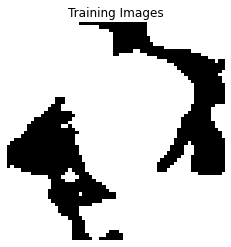

In [10]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset


# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],cmap='Greys', padding=2, normalize=True).cpu(),(1,2,0)))

In [10]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Discriminator Code



In [13]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [14]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [15]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
lab = get_truncated_normal(mean=0, sd=1, low=.7, upp=1.2)
labf=lab.rvs()
labs=get_truncated_normal(mean=0, sd=1, low=0, upp=0.3)
labsf=labs.rvs()
real_label = labf
fake_label = labsf
real_label=0.9
fake_label=0.1

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [187]:
fake_label

0.1

In [38]:
# Training Loop

# Lists to keep track of progress
lr = 0.00002 ## training again with less learning rate 
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        #for p in list(filter(lambda p: p.grad is not None, netD.parameters())):
           # print(p.grad.data.norm(2).item())
        
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        
        errD_fake.backward()
        #for p in list(filter(lambda p: p.grad is not None, netD.parameters())):
             #print(p.grad.data.norm(2).item())
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        #for p in list(filter(lambda p: p.grad is not None, netG.parameters())):
                # print(p.grad.data.norm(2).item())
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/100][0/46]	Loss_D: 0.8226	Loss_G: 3.2552	D(x): 0.9497	D(G(z)): 0.2935 / 0.0308
[1/100][0/46]	Loss_D: 0.9645	Loss_G: 3.2052	D(x): 0.9383	D(G(z)): 0.3845 / 0.0370
[2/100][0/46]	Loss_D: 0.7246	Loss_G: 2.7751	D(x): 0.9069	D(G(z)): 0.1895 / 0.0536
[3/100][0/46]	Loss_D: 0.8334	Loss_G: 1.7164	D(x): 0.7599	D(G(z)): 0.2258 / 0.1778
[4/100][0/46]	Loss_D: 0.6900	Loss_G: 2.4261	D(x): 0.8949	D(G(z)): 0.1305 / 0.0791
[5/100][0/46]	Loss_D: 0.7165	Loss_G: 2.5719	D(x): 0.8901	D(G(z)): 0.1910 / 0.0655
[6/100][0/46]	Loss_D: 0.6746	Loss_G: 2.1620	D(x): 0.8907	D(G(z)): 0.1176 / 0.1018
[7/100][0/46]	Loss_D: 0.6677	Loss_G: 2.1372	D(x): 0.8934	D(G(z)): 0.0780 / 0.1026
[8/100][0/46]	Loss_D: 0.7170	Loss_G: 2.9810	D(x): 0.9350	D(G(z)): 0.2036 / 0.0400
[9/100][0/46]	Loss_D: 0.7583	Loss_G: 1.6377	D(x): 0.8100	D(G(z)): 0.1260 / 0.1981
[10/100][0/46]	Loss_D: 0.9513	Loss_G: 2.3788	D(x): 0.9226	D(G(z)): 0.3759 / 0.0877
[11/100][0/46]	Loss_D: 0.8779	Loss_G: 1.9534	D(x): 0.7526	D(G(z)): 0.24

[99/100][0/46]	Loss_D: 0.6925	Loss_G: 2.7974	D(x): 0.9132	D(G(z)): 0.1462 / 0.0492


In [18]:
real_cpu = data.to(device)
b_size = real_cpu.size(0)
label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
(real_cpu).view(-1).shape
print(label)


tensor([0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
        0.9000, 0.9000], device='cuda:0')


In [183]:
torch.save(netG.state_dict(), 'model_weights.pth')
torch.save(netD.state_dict(), 'model_weights_for_discriminator.pth')
model = models.vgg16() # we do not specify pretrained=True, i.e. do not load default weights
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

In [11]:
import torch
import numpy as np
import h5py
import tifffile
from scipy.ndimage.filters import median_filter
from skimage.filters import threshold_otsu
from collections import Counter
b_size=128
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load('model_weights.pth'))
netG.eval()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [20]:
netD(real_cpu).shape

torch.Size([20, 1, 1, 1])

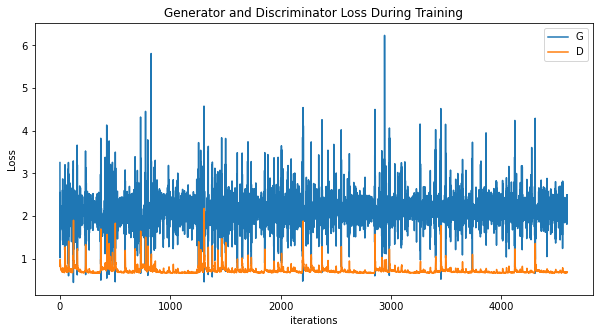

In [39]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




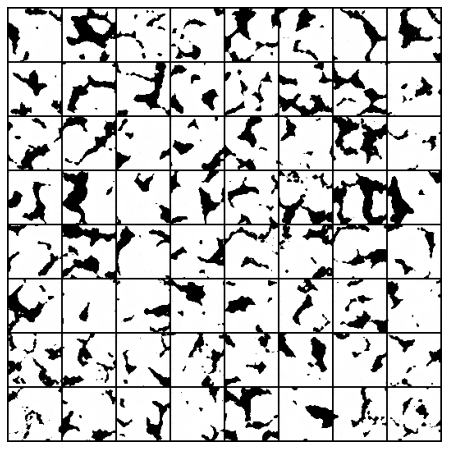

In [40]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




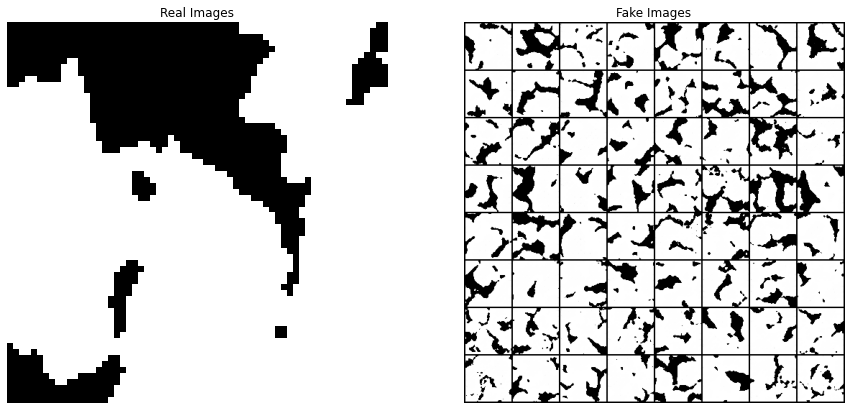

In [166]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[1].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [167]:
total_norm = []
parameters = [p for p in netG.parameters() if p.grad is not None and p.requires_grad]
for p in parameters:
    param_norm = p.grad.detach().data.norm(2)
    total_norm.append(param_norm)

total_norm

[tensor(61.9254, device='cuda:0'),
 tensor(1.8638, device='cuda:0'),
 tensor(1.7768, device='cuda:0'),
 tensor(19.2881, device='cuda:0'),
 tensor(1.2248, device='cuda:0'),
 tensor(1.2784, device='cuda:0'),
 tensor(25.8479, device='cuda:0'),
 tensor(2.4508, device='cuda:0'),
 tensor(2.3507, device='cuda:0'),
 tensor(11.6839, device='cuda:0'),
 tensor(0.1586, device='cuda:0'),
 tensor(0.1846, device='cuda:0'),
 tensor(1.5458, device='cuda:0')]

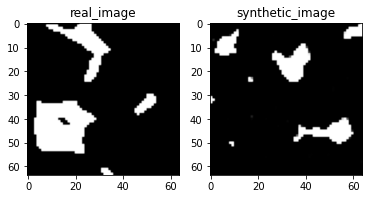

In [20]:
torch.manual_seed(59)
noise_test = torch.randn(b_size, nz, 1, 1, device=device)
test1=netG(noise_test)
test1_final=test1[0].reshape(64,64).cpu().detach().numpy()
plt.subplot(1,2,1)
plt.title('real_image')
plt.imshow(dataset[2].reshape(64,64),cmap='Greys')
plt.subplot(1,2,2)
plt.title('synthetic_image')
plt.imshow(test1_final,cmap='Greys')

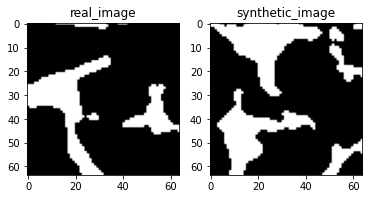

In [16]:

noise_test = torch.randn(b_size, nz, 1, 1, device=device)
test1=netG(noise_test)
test1_final=test1[0].reshape(64,64).cpu().detach().numpy()
plt.subplot(1,2,1)
plt.title('real_image')
plt.imshow(dataset[400].reshape(64,64),cmap='Greys')
plt.subplot(1,2,2)
plt.title('synthetic_image')
#test1_final = median_filter(test1_final,size=(3,3))
test1_final = median_filter(test1_final,size=(3,3))

threshold_global_otsu = threshold_otsu(test1_final)

segmented_image = (test1_final >= threshold_global_otsu).astype(np.int32)

plt.imshow(segmented_image,cmap='Greys')

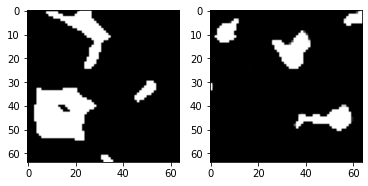

In [24]:
torch.manual_seed(59)
noise_test = torch.randn(b_size, nz, 1, 1, device=device)
test1=netG(noise_test)
test1_final=test1[0].reshape(64,64).cpu().detach().numpy()
plt.subplot(1,2,1)
plt.imshow(dataset[2].reshape(64,64),cmap='Greys')
plt.subplot(1,2,2)
test1_final = median_filter(test1_final,size=(3,3))
plt.imshow(test1_final,cmap='Greys')

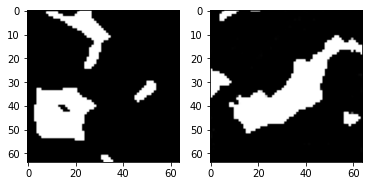

In [25]:
torch.manual_seed(40)
noise_test = torch.randn(b_size, nz, 1, 1, device=device)
test1=netG(noise_test)
test1_final=test1[0].reshape(64,64).cpu().detach().numpy()
plt.subplot(1,2,1)
plt.imshow(dataset[2].reshape(64,64),cmap='Greys')
plt.subplot(1,2,2)
#test1_final = median_filter(test1_final,size=(3,3))
plt.imshow(test1_final,cmap='Greys')

In [61]:
import numpy as np
import h5py
import tifffile
from scipy.ndimage.filters import median_filter
from skimage.filters import threshold_otsu
from collections import Counter


In [82]:
im_in = median_filter(test1_final,size=(3,3))

#cutaway outer noise area
#im_in = im_in[40:240, 40:240, 40:240]

#Normalize to range zero and one


#Threshhold Image


In [28]:
for p in list(filter(lambda p: p.grad is not None, netD.parameters())):
    print(p.grad.data.norm(2).item())

58.388282775878906
29.49303436279297
1.1896981000900269
0.7278082370758057
18.242694854736328
1.0383614301681519
0.5714901685714722
10.922709465026855
0.7163287997245789
0.9639531373977661
30.0150146484375


In [29]:
# Things to do now
# increase the number of epochs : i see that noise is getting damped with increase in iterations
# increase the size of datasets here . im only doing with 1276, where lukas mosser have done with 3660 average. atleast make it upto 3500
# label smoothening have done ; left with adding noise to inputs here ans somehow will do now. 
## you have checked for exploding gradients nothing to worry about it , its all below 100
# Gan are very unstable during training; you could see lot of spikes and whatver there too. in order to find optimal hyperparameteres, its a tedious task to go through number of iterations , in order to curb fraction of it ; we can do one end label smoothening and adding white noise ; now i will look upon this ;
# i have increased the number of epochs let see what i got here.

epochs 50 seems to be a good choice , for 100 epochs its overfitting here 


SyntaxError: invalid syntax (Temp/ipykernel_1560/1368423976.py, line 9)

In [ ]:
# information about the hyperparameters here
# first its trained with learning rate of 0.0002 for 200 epochs and then again, with that parameters as intial parameters it was trained for 100 more epochs with learning rate 1/10th of previous one
#reallabel0.9
# the number of training images were 5743, which were generated using the stride of 20 
# in colormap,image plot its important to keep cmap as "Greys"